In [1]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.ldamulticore import LdaMulticore
from operator import itemgetter

from top2vec import Top2Vec

from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

import os

# Load process_csv_stage_1.csv

In [2]:
df = pd.read_csv('process_csv_stage_1.csv')
df.columns = ['old_index','preprocessed_text']
df

old_index                                  preprocessed_text
0              1  good morning name appreciate could help put st...
1              2  upgraded card tell agent upgrade anniversary d...
2             10  chase card report however fraudulent applicati...
3             11  try book ticket come across offer apply toward...
4             14  grand son give check deposit chase account fun...
...          ...                                                ...
21067      78303  chase card customer well decade offer multiple...
21068      78309  wednesday call chas visa credit card provider ...
21069      78310  familiar pay understand great risk provide con...
21070      78311  flawless credit chase credit card chase freedo...
21071      78312  roughly year ago close account morgan chase ba...

[21072 rows x 2 columns]

# Load complaint_what_happened from json

In [3]:
# load raw complaint json into raw df 
raw = pd.json_normalize(json.load(open("complaints-2021-05-14_08_16_.json")))

# renaming column
raw.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

# drop unnecessary columns
raw.drop(['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'sub_issue','consumer_consent_provided'],axis=1,inplace=True)

# drop null values
raw['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
raw.dropna(inplace=True)

# clear masked values
def remove_mask(text):
    masked_text_pattern = r"\b[x|X]{2,20}"
    return re.sub(masked_text_pattern,'',text)

removed_mask = raw.complaint_what_happened.apply(remove_mask)

# Topic Modelling

In [4]:
## Initialise corpus, dictionary and topic numbers for NMF and LDA
texts = df['preprocessed_text'].str.split(' ')

dictionary = Dictionary(texts)

dictionary.filter_extremes(
    no_below=0.05,
    no_above=0.80,
    keep_n=None
)

corpus = [dictionary.doc2bow(text) for text in texts]

topic_nums = list(np.arange(2,11))

## Non-Negative Matrix Factorisation

In [5]:
nmf_coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=20,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    nmf_coherence_scores.append(round(cm.get_coherence(), 5))
    print(f'k = {num}; Coherence Score = {round(cm.get_coherence(), 5)}')

k = 2; Coherence Score = 0.35004
k = 3; Coherence Score = 0.36491
k = 4; Coherence Score = 0.41509
k = 5; Coherence Score = 0.41073
k = 6; Coherence Score = 0.39226
k = 7; Coherence Score = 0.41809
k = 8; Coherence Score = 0.43268
k = 9; Coherence Score = 0.42966
k = 10; Coherence Score = 0.43193


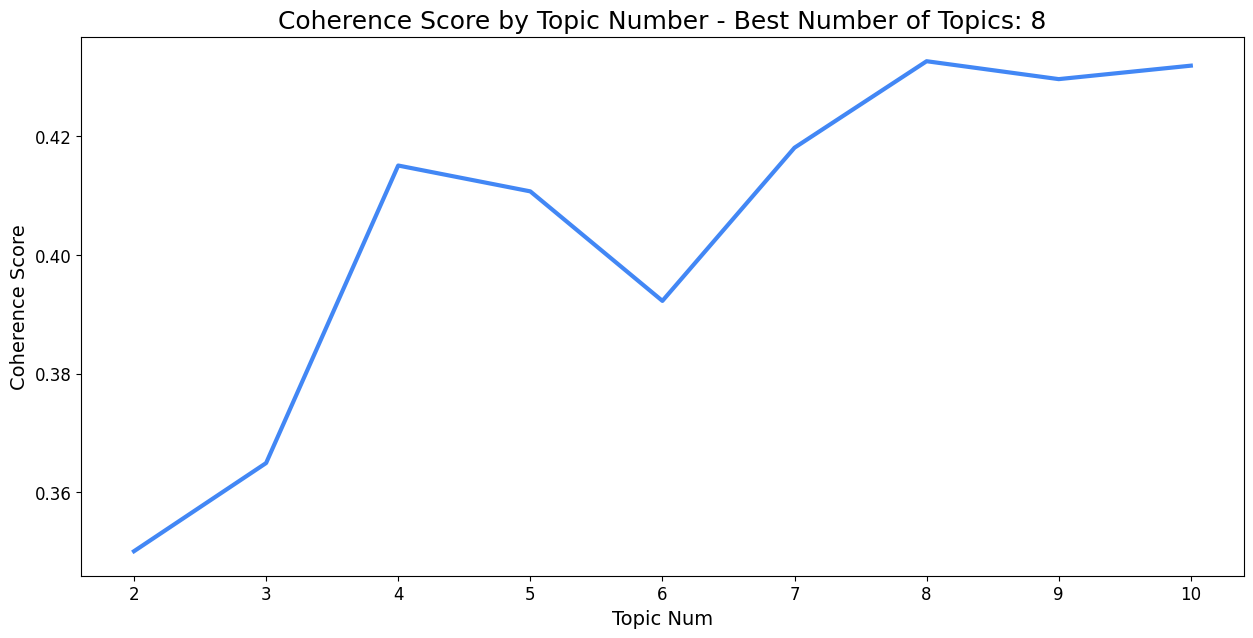

In [6]:
nmf_scores = list(zip(topic_nums, nmf_coherence_scores))
nmf_best_k = sorted(nmf_scores, key=itemgetter(1), reverse=True)[0][0]

fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    nmf_coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(nmf_best_k), fontsize=18)
plt.xticks(topic_nums, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [7]:
final_nmf = Nmf(
   corpus=corpus,
    num_topics=nmf_best_k,
    id2word=dictionary,
    chunksize=2000,
    passes=20,
    kappa=.1,
    minimum_probability=0.01,
    w_max_iter=300,
    w_stop_condition=0.0001,
    h_max_iter=100,
    h_stop_condition=0.001,
    eval_every=10,
    normalize=True,
    random_state=42
    )
final_nmf.print_topics()

[(0,
  '0.035*"loan" + 0.015*"service" + 0.015*"document" + 0.012*"mortgage" + 0.012*"letter" + 0.011*"state" + 0.011*"receive" + 0.011*"home" + 0.011*"modification" + 0.010*"request"'),
 (1,
  '0.027*"charge" + 0.026*"call" + 0.020*"say" + 0.015*"make" + 0.014*"claim" + 0.014*"back" + 0.013*"day" + 0.012*"money" + 0.011*"transaction" + 0.011*"dispute"'),
 (2,
  '0.112*"bank" + 0.102*"account" + 0.050*"check" + 0.031*"money" + 0.025*"fund" + 0.025*"deposit" + 0.018*"close" + 0.017*"transaction" + 0.013*"branch" + 0.010*"customer"'),
 (3,
  '0.046*"would" + 0.037*"call" + 0.034*"tell" + 0.018*"get" + 0.018*"ask" + 0.017*"could" + 0.016*"receive" + 0.013*"say" + 0.012*"time" + 0.012*"back"'),
 (4,
  '0.192*"account" + 0.039*"check" + 0.027*"close" + 0.026*"open" + 0.019*"transfer" + 0.015*"number" + 0.014*"deposit" + 0.013*"branch" + 0.012*"fund" + 0.012*"business"'),
 (5,
  '0.193*"card" + 0.132*"credit" + 0.037*"charge" + 0.022*"purchase" + 0.017*"use" + 0.010*"apply" + 0.010*"balance"

In [8]:
nmf_topics = []
for index, topic in final_nmf.show_topics(formatted=False, num_topics=nmf_best_k, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    nmf_topics.append([w[0] for w in topic])

Topic: 0 
Words: ['loan', 'service', 'document', 'mortgage', 'letter', 'state', 'receive', 'home', 'modification', 'request']
Topic: 1 
Words: ['charge', 'call', 'say', 'make', 'claim', 'back', 'day', 'money', 'transaction', 'dispute']
Topic: 2 
Words: ['bank', 'account', 'check', 'money', 'fund', 'deposit', 'close', 'transaction', 'branch', 'customer']
Topic: 3 
Words: ['would', 'call', 'tell', 'get', 'ask', 'could', 'receive', 'say', 'time', 'back']
Topic: 4 
Words: ['account', 'check', 'close', 'open', 'transfer', 'number', 'deposit', 'branch', 'fund', 'business']
Topic: 5 
Words: ['card', 'credit', 'charge', 'purchase', 'use', 'apply', 'balance', 'report', 'fee', 'offer']
Topic: 6 
Words: ['credit', 'report', 'consumer', 'act', 'debt', 'request', 'information', 'reporting', 'agency', 'payment']
Topic: 7 
Words: ['payment', 'pay', 'make', 'bank', 'fee', 'balance', 'month', 'interest', 'time', 'due']


### Tuning

In [9]:
nmf_coherence_scores = []

for pass_num in range(20,41,5): # [20,25,30,35,40]
    for chunk in [500,1000,2000]: # [500,1000,2000]
        nmf = Nmf(
            corpus=corpus,
            num_topics=nmf_best_k,
            id2word=dictionary,
            chunksize=chunk, #
            passes=pass_num, #
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=42
        )
        cm = CoherenceModel(
            model=nmf,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        
        nmf_coherence_scores.append((pass_num,chunk,round(cm.get_coherence(), 5)))
        print(f'passes = {pass_num}; chunksize = {chunk}; Coherence Score = {round(cm.get_coherence(), 5)}')

passes = 20; chunksize = 500; Coherence Score = 0.44291
passes = 20; chunksize = 1000; Coherence Score = 0.44925
passes = 20; chunksize = 2000; Coherence Score = 0.43268
passes = 25; chunksize = 500; Coherence Score = 0.4435
passes = 25; chunksize = 1000; Coherence Score = 0.45124
passes = 25; chunksize = 2000; Coherence Score = 0.4438
passes = 30; chunksize = 500; Coherence Score = 0.44336
passes = 30; chunksize = 1000; Coherence Score = 0.45495
passes = 30; chunksize = 2000; Coherence Score = 0.43913
passes = 35; chunksize = 500; Coherence Score = 0.44287
passes = 35; chunksize = 1000; Coherence Score = 0.45969
passes = 35; chunksize = 2000; Coherence Score = 0.4472
passes = 40; chunksize = 500; Coherence Score = 0.44359
passes = 40; chunksize = 1000; Coherence Score = 0.45904
passes = 40; chunksize = 2000; Coherence Score = 0.44983


In [10]:
# get the best parameters
nmf_best_params = sorted(nmf_coherence_scores,key=lambda tup: -1*tup[2])[0]
best_pass_num = nmf_best_params[0]
best_chunksize = nmf_best_params[1]
print(f'best_pass_num: {best_pass_num}; best_chunksize: {best_chunksize}')

final_tune_nmf = Nmf(
    corpus=corpus,
    num_topics=nmf_best_k, 
    id2word=dictionary,
    chunksize=best_chunksize,
    passes=best_pass_num,
    kappa=.1,
    minimum_probability=0.01,
    w_max_iter=300,
    w_stop_condition=0.0001,
    h_max_iter=100,
    h_stop_condition=0.001,
    eval_every=10,
    normalize=True,
    random_state=42
    )
final_tune_nmf.print_topics()

best_pass_num: 35; best_chunksize: 1000


[(0,
  '0.061*"payment" + 0.034*"pay" + 0.034*"make" + 0.021*"would" + 0.018*"time" + 0.018*"month" + 0.017*"balance" + 0.016*"receive" + 0.016*"due" + 0.015*"charge"'),
 (1,
  '0.031*"check" + 0.028*"would" + 0.023*"tell" + 0.021*"get" + 0.019*"money" + 0.018*"say" + 0.018*"day" + 0.014*"could" + 0.011*"call" + 0.011*"ask"'),
 (2,
  '0.121*"bank" + 0.084*"account" + 0.024*"transaction" + 0.015*"money" + 0.014*"fund" + 0.012*"fraud" + 0.011*"close" + 0.010*"customer" + 0.010*"transfer" + 0.008*"debit"'),
 (3,
  '0.366*"account" + 0.062*"close" + 0.051*"open" + 0.034*"check" + 0.026*"deposit" + 0.018*"fund" + 0.018*"branch" + 0.015*"transfer" + 0.013*"new" + 0.013*"access"'),
 (4,
  '0.160*"credit" + 0.058*"report" + 0.020*"consumer" + 0.014*"debt" + 0.014*"information" + 0.013*"reporting" + 0.013*"request" + 0.013*"dispute" + 0.013*"act" + 0.012*"inquiry"'),
 (5,
  '0.034*"call" + 0.018*"receive" + 0.016*"say" + 0.015*"claim" + 0.014*"send" + 0.013*"number" + 0.013*"letter" + 0.013*"ba

In [11]:
nmf_topics = []
for index, topic in final_tune_nmf.show_topics(formatted=False, num_topics=nmf_best_k, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    nmf_topics.append([w[0] for w in topic])

Topic: 0 
Words: ['payment', 'pay', 'make', 'would', 'time', 'month', 'balance', 'receive', 'due', 'charge']
Topic: 1 
Words: ['check', 'would', 'tell', 'get', 'money', 'say', 'day', 'could', 'call', 'ask']
Topic: 2 
Words: ['bank', 'account', 'transaction', 'money', 'fund', 'fraud', 'close', 'customer', 'transfer', 'debit']
Topic: 3 
Words: ['account', 'close', 'open', 'check', 'deposit', 'fund', 'branch', 'transfer', 'new', 'access']
Topic: 4 
Words: ['credit', 'report', 'consumer', 'debt', 'information', 'reporting', 'request', 'dispute', 'act', 'inquiry']
Topic: 5 
Words: ['call', 'receive', 'say', 'claim', 'send', 'number', 'letter', 'back', 'email', 'state']
Topic: 6 
Words: ['card', 'charge', 'purchase', 'use', 'credit', 'fee', 'transaction', 'service', 'offer', 'fraudulent']
Topic: 7 
Words: ['loan', 'mortgage', 'service', 'home', 'modification', 'document', 'property', 'request', 'state', 'borrower']


In [12]:
filename_nmf = os.path.join(os.getcwd(),'topic_models',"final_tune_nmf")
final_tune_nmf.save(filename_nmf)

## Latent Dirichlet Allocation

In [13]:
lda_coherence_scores = []

for num in topic_nums:
    lda = LdaMulticore(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        workers=7,
        passes=20,
        chunksize=2000,
        iterations=100,
        minimum_probability=0.01,
        alpha='asymmetric',
        eta= 'auto',
        per_word_topics=True,
        eval_every=10,
        random_state=42
    )
    cm = CoherenceModel(
        model=lda,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    lda_coherence_scores.append(round(cm.get_coherence(), 5))
    print(f'k = {num}; Coherence Score = {round(cm.get_coherence(), 5)}')

k = 2; Coherence Score = 0.33726
k = 3; Coherence Score = 0.37846
k = 4; Coherence Score = 0.36165
k = 5; Coherence Score = 0.38924
k = 6; Coherence Score = 0.37487
k = 7; Coherence Score = 0.3908
k = 8; Coherence Score = 0.40313
k = 9; Coherence Score = 0.40894
k = 10; Coherence Score = 0.40259


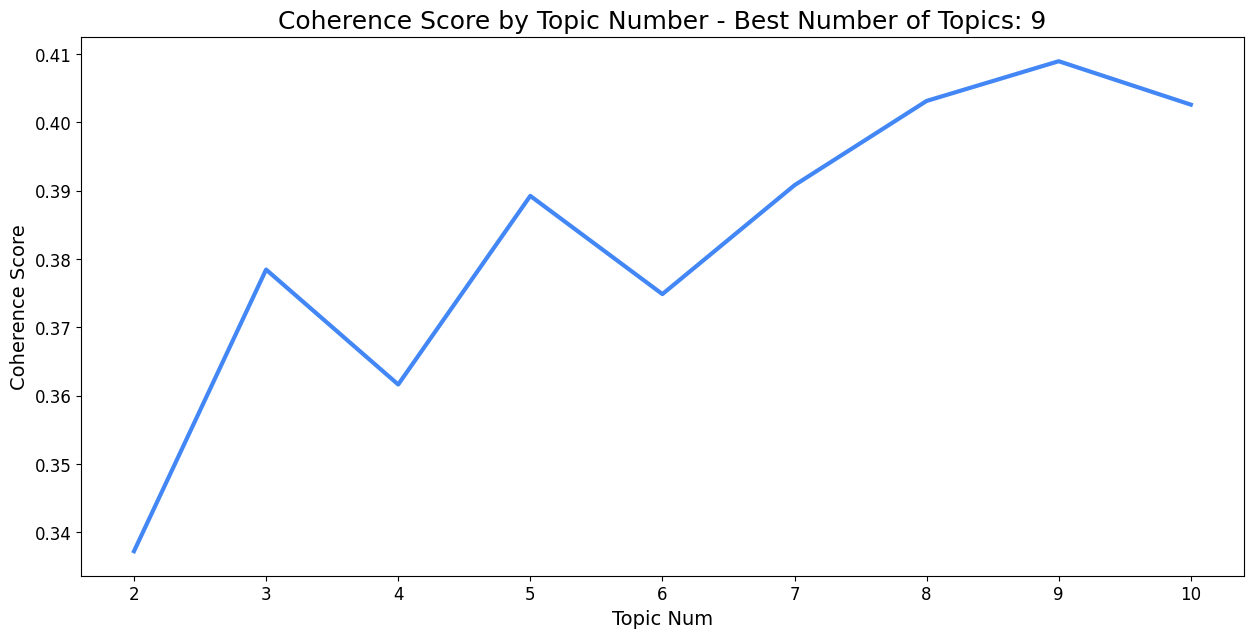

In [14]:
lda_scores = list(zip(topic_nums, lda_coherence_scores))
lda_best_k = sorted(lda_scores, key=itemgetter(1), reverse=True)[0][0]

fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    lda_coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(lda_best_k), fontsize=18)
plt.xticks(topic_nums, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [15]:
lda_coherence_scores = []

# use number of topic 9
# this time we tune passes and chunksize
for pass_num in range(20,51,5): # [20,25,30,35,40,45,50]
    for chunk in [50,100,200,300]: # [50,100,200,300]
        lda = LdaMulticore(
            corpus=corpus,
            num_topics=lda_best_k,
            id2word=dictionary,
            workers=7,
            passes=pass_num, #
            chunksize=chunk, #
            iterations=100,
            minimum_probability=0.01,
            alpha='asymmetric',
            eta= 'auto',
            per_word_topics=True,
            eval_every=10,
            random_state=42
        )
        cm = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        lda_coherence_scores.append((pass_num,chunk,round(cm.get_coherence(), 5)))
        print(f'passes = {pass_num}; chunksize = {chunk}; Coherence Score = {round(cm.get_coherence(), 5)}')

passes = 20; chunksize = 50; Coherence Score = 0.42833
passes = 20; chunksize = 100; Coherence Score = 0.43795
passes = 20; chunksize = 200; Coherence Score = 0.42094
passes = 20; chunksize = 300; Coherence Score = 0.40814
passes = 25; chunksize = 50; Coherence Score = 0.43514
passes = 25; chunksize = 100; Coherence Score = 0.4458
passes = 25; chunksize = 200; Coherence Score = 0.42019
passes = 25; chunksize = 300; Coherence Score = 0.4072
passes = 30; chunksize = 50; Coherence Score = 0.43589
passes = 30; chunksize = 100; Coherence Score = 0.44308
passes = 30; chunksize = 200; Coherence Score = 0.42449
passes = 30; chunksize = 300; Coherence Score = 0.41497
passes = 35; chunksize = 50; Coherence Score = 0.44667
passes = 35; chunksize = 100; Coherence Score = 0.44633
passes = 35; chunksize = 200; Coherence Score = 0.42793
passes = 35; chunksize = 300; Coherence Score = 0.41967
passes = 40; chunksize = 50; Coherence Score = 0.4506
passes = 40; chunksize = 100; Coherence Score = 0.4447
p

In [16]:
# get the best parameters
lda_best_params = sorted(lda_coherence_scores,key=lambda tup: -1*tup[2])[0]
best_pass_num = lda_best_params[0]
best_chunksize = lda_best_params[1]
print(f'best_pass_num: {best_pass_num}; best_chunksize: {best_chunksize}')

final_lda = LdaMulticore(
    corpus=corpus,
    num_topics=lda_best_k,
    id2word=dictionary,
    workers=7,
    passes=best_pass_num,
    chunksize=best_chunksize,
    iterations=100,
    minimum_probability=0.01,
    alpha='symmetric',
    eta= 'auto',
    per_word_topics=True,
    eval_every=10,
    random_state=42
)
final_lda.print_topics()

best_pass_num: 40; best_chunksize: 50


[(0,
  '0.096*"credit" + 0.057*"card" + 0.045*"account" + 0.030*"payment" + 0.027*"report" + 0.016*"pay" + 0.015*"late" + 0.013*"close" + 0.011*"make" + 0.011*"never"'),
 (1,
  '0.055*"charge" + 0.038*"transaction" + 0.034*"card" + 0.031*"claim" + 0.024*"fraud" + 0.022*"account" + 0.019*"make" + 0.017*"fraudulent" + 0.013*"bank" + 0.013*"debit"'),
 (2,
  '0.018*"information" + 0.017*"request" + 0.017*"letter" + 0.015*"provide" + 0.013*"state" + 0.012*"report" + 0.011*"credit" + 0.011*"inquiry" + 0.011*"debt" + 0.010*"complaint"'),
 (3,
  '0.055*"bank" + 0.022*"name" + 0.019*"money" + 0.017*"fraud" + 0.015*"use" + 0.014*"help" + 0.013*"number" + 0.011*"security" + 0.011*"year" + 0.011*"address"'),
 (4,
  '0.054*"payment" + 0.044*"fee" + 0.038*"pay" + 0.028*"interest" + 0.023*"balance" + 0.021*"charge" + 0.018*"make" + 0.017*"rate" + 0.017*"amount" + 0.015*"month"'),
 (5,
  '0.047*"card" + 0.025*"credit" + 0.021*"dispute" + 0.018*"receive" + 0.018*"charge" + 0.015*"purchase" + 0.014*"off

In [17]:
lda_topics = []
for index, topic in final_lda.show_topics(formatted=False, num_topics=lda_best_k, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    lda_topics.append([w[0] for w in topic])

Topic: 0 
Words: ['credit', 'card', 'account', 'payment', 'report', 'pay', 'late', 'close', 'make', 'never']
Topic: 1 
Words: ['charge', 'transaction', 'card', 'claim', 'fraud', 'account', 'make', 'fraudulent', 'bank', 'debit']
Topic: 2 
Words: ['information', 'request', 'letter', 'provide', 'state', 'report', 'credit', 'inquiry', 'debt', 'complaint']
Topic: 3 
Words: ['bank', 'name', 'money', 'fraud', 'use', 'help', 'number', 'security', 'year', 'address']
Topic: 4 
Words: ['payment', 'fee', 'pay', 'interest', 'balance', 'charge', 'make', 'rate', 'amount', 'month']
Topic: 5 
Words: ['card', 'credit', 'dispute', 'receive', 'charge', 'purchase', 'offer', 'refund', 'service', 'merchant']
Topic: 6 
Words: ['account', 'check', 'bank', 'fund', 'deposit', 'money', 'branch', 'close', 'day', 'transfer']
Topic: 7 
Words: ['loan', 'mortgage', 'home', 'payment', 'property', 'modification', 'sale', 'year', 'foreclosure', 'house']
Topic: 8 
Words: ['call', 'tell', 'would', 'say', 'get', 'ask', 'bac

In [18]:
print('\nPerplexity: ', final_lda.log_perplexity(corpus))  

coherence_model_lda = CoherenceModel(model=final_lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.819713775270494

Coherence Score:  0.4461557550352395


In [19]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
coherence_per_topic 

[0.3924092832117311,
 0.46627234945816287,
 0.38470116473337146,
 0.38205441414963415,
 0.46047607346322755,
 0.44342853801311294,
 0.44900504240876976,
 0.6013610988159727,
 0.4356938310631736]

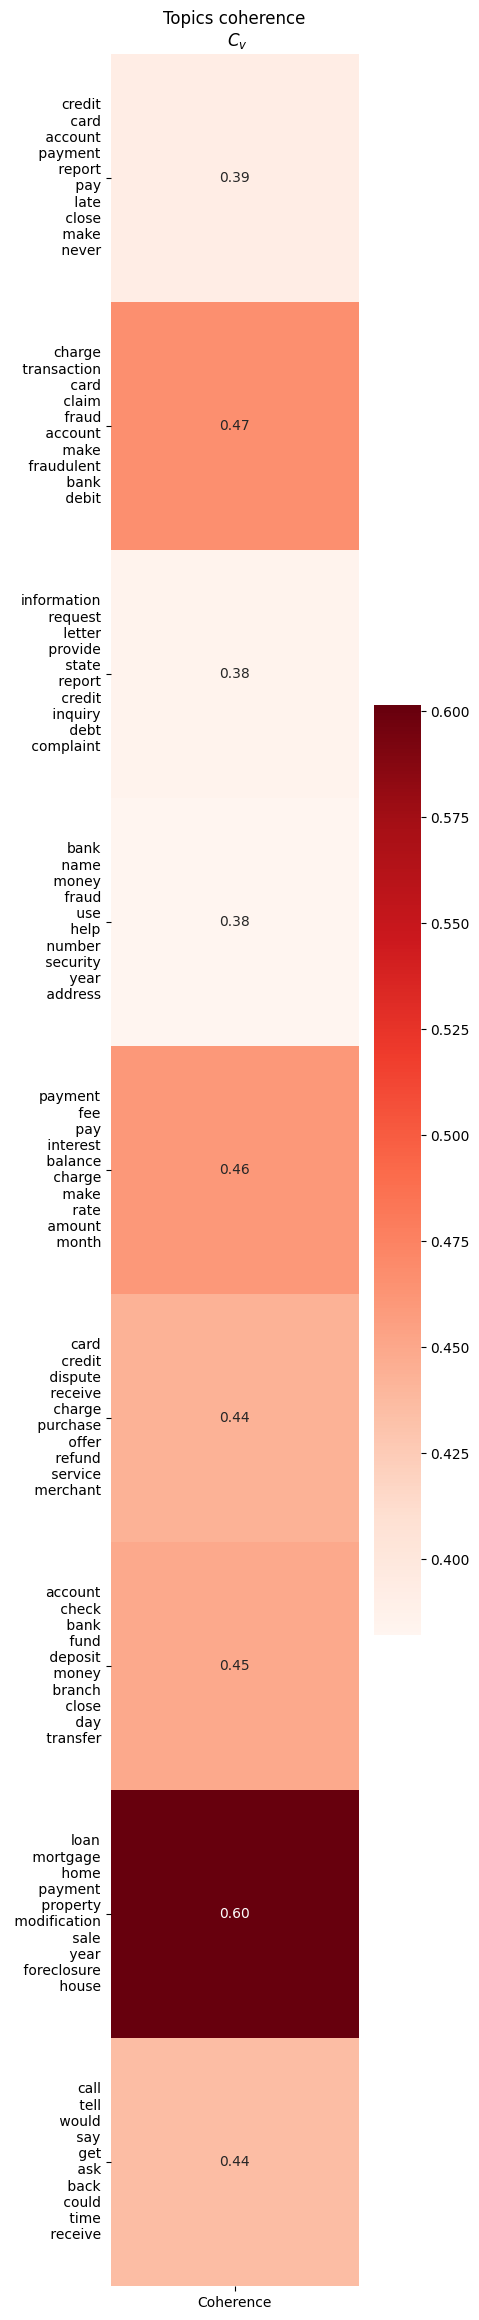

In [20]:
topics_str = [ '\n '.join(t) for t in lda_topics ]
data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(4, 35) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

In [21]:
filename_lda = os.path.join(os.getcwd(),'topic_models',"final_tune_lda")
final_lda.save(filename_lda)

## Top2Vec

In [40]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42}
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

top2vec = Top2Vec(
    documents= list(removed_mask), 
    speed='deep-learn', 
    workers=8, 
    min_count = 50, 
    embedding_model='universal-sentence-encoder', 
    umap_args = umap_args, 
    hdbscan_args = hdbscan_args)

top2vec.get_num_topics()

2024-07-03 11:21:36,650 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2024-07-03 11:22:01,479 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2024-07-03 11:22:15,718 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-07-03 11:22:55,067 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-07-03 11:23:32,923 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-07-03 11:23:48,960 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


7

In [41]:
top2vec.topic_words

array([['cfpb', 'autopay', 'chase', 'wamu', 'overdrawn', 'garnishment',
        'defaulted', 'overdrafts', 'chargeback', 'overdraft',
        'refinanced', 'bank', 'defrauded', 'fdic', 'creditor',
        'creditors', 'heloc', 'banking', 'refi', 'lender', 'csr',
        'refinance', 'fraudulent', 'foreclose', 'repossession', 'acct',
        'ssn', 'debited', 'owed', 'credit', 'delinquent', 'depositing',
        'banks', 'overpayment', 'cashing', 'visa', 'debits', 'debit',
        'fraudulently', 'repossessed', 'banker', 'foreclosure',
        'jpmorgan', 'lenders', 'financial', 'refinancing', 'defraud',
        'mortgages', 'debt', 'debts'],
       ['dispute', 'garnishment', 'creditor', 'defrauded', 'disputes',
        'creditors', 'disputing', 'litigation', 'collections',
        'fraudulent', 'bureaus', 'autopay', 'cfpb', 'credit',
        'repossession', 'owed', 'bbb', 'disputed', 'rma', 'defaulted',
        'ssn', 'arrears', 'chargeback', 'investigated', 'investigation',
        'f

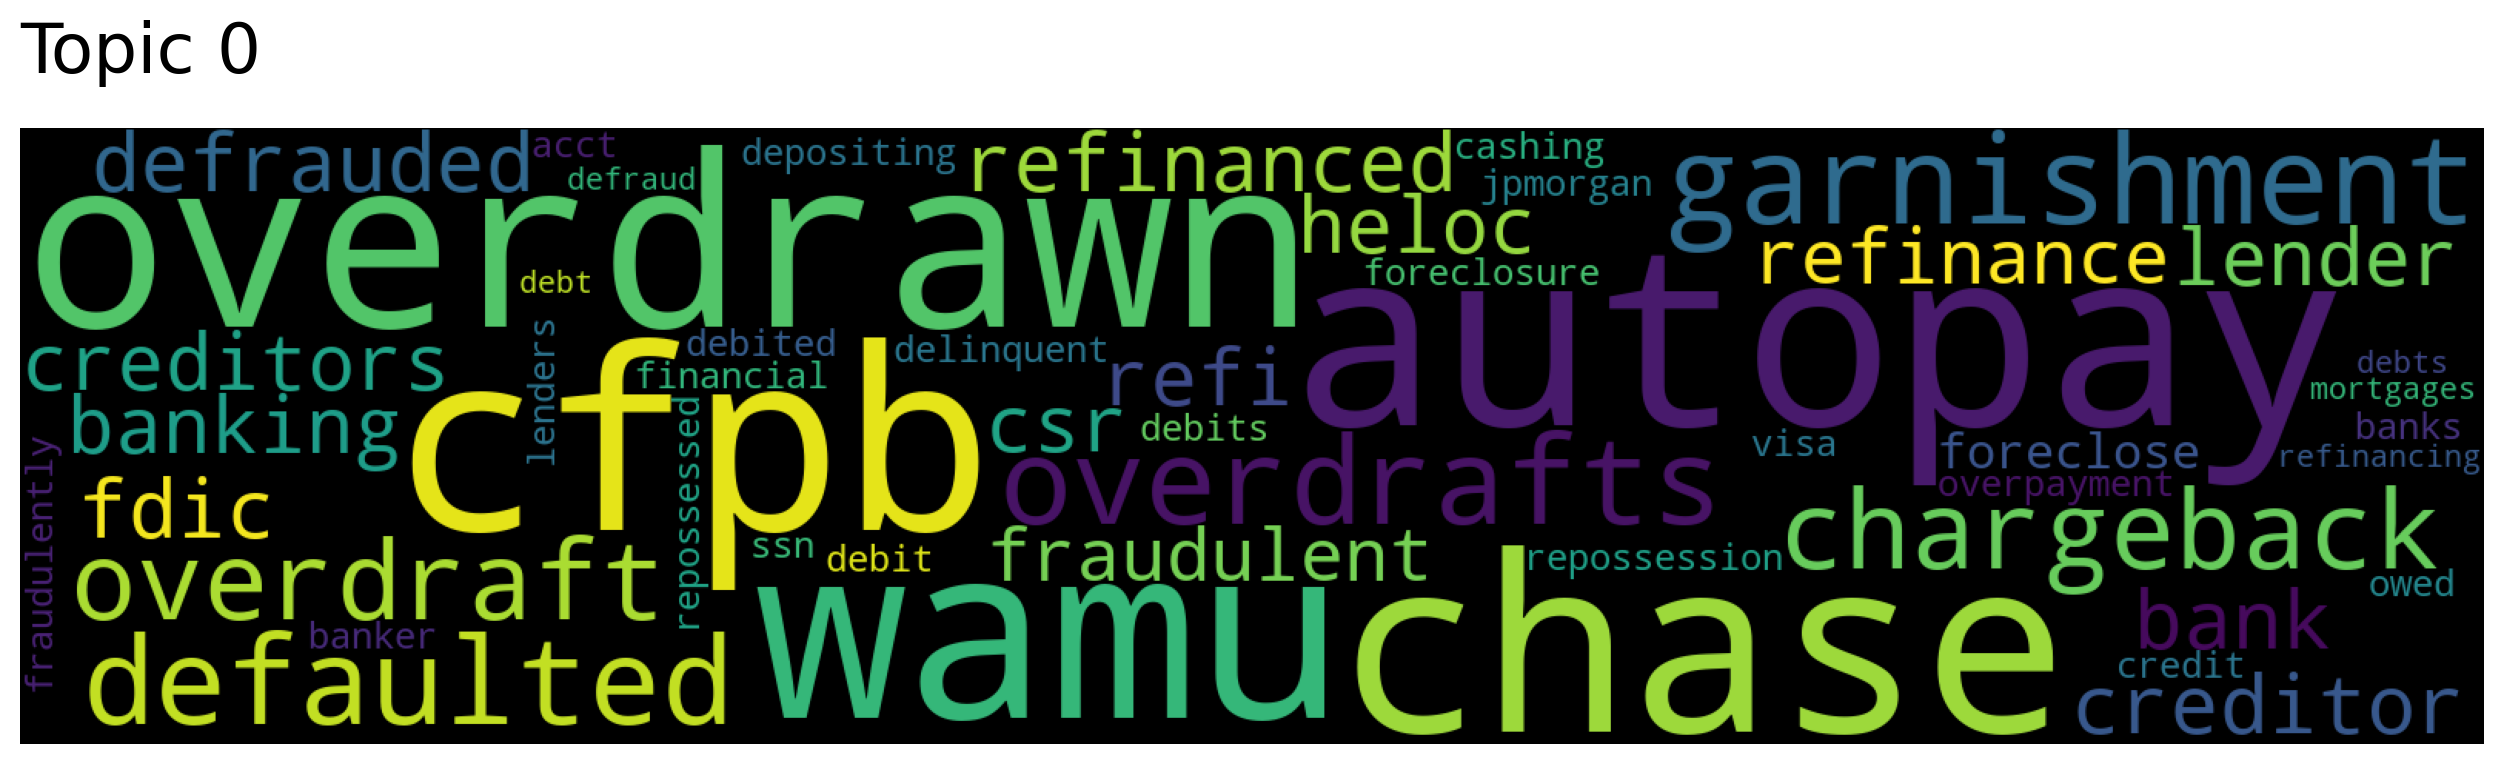

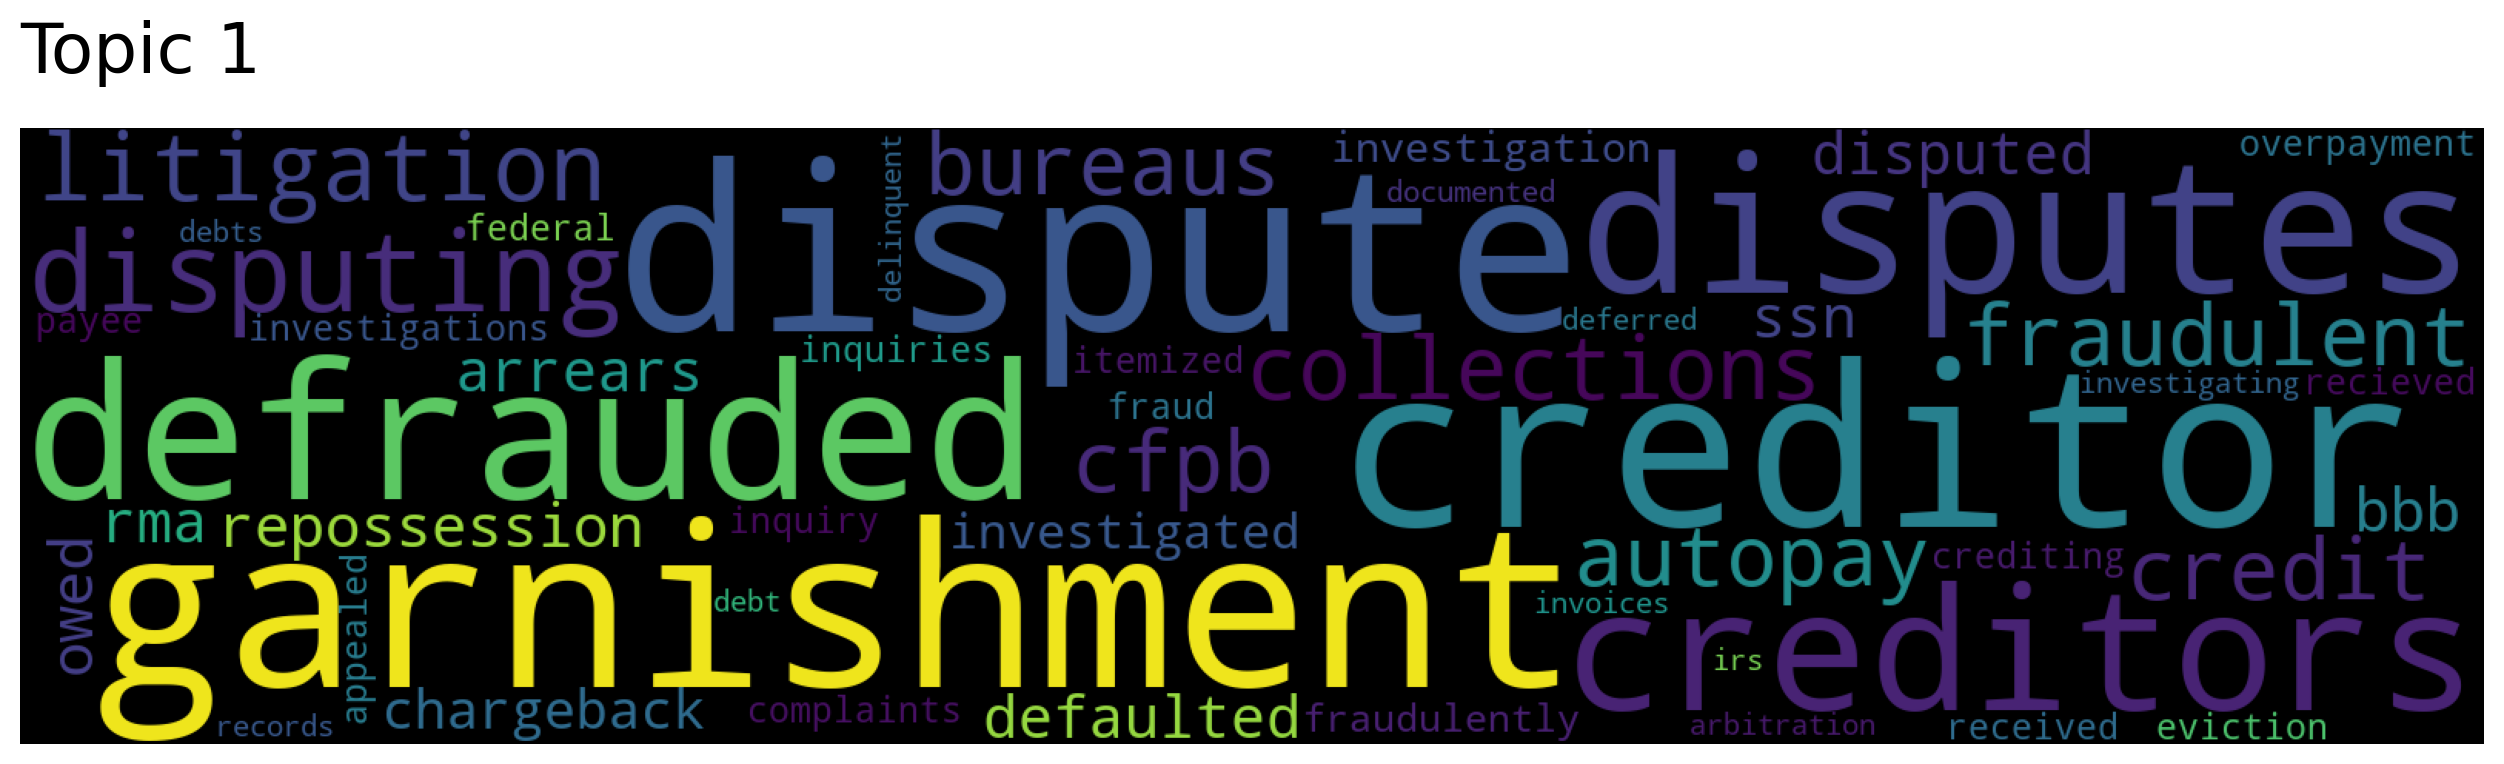

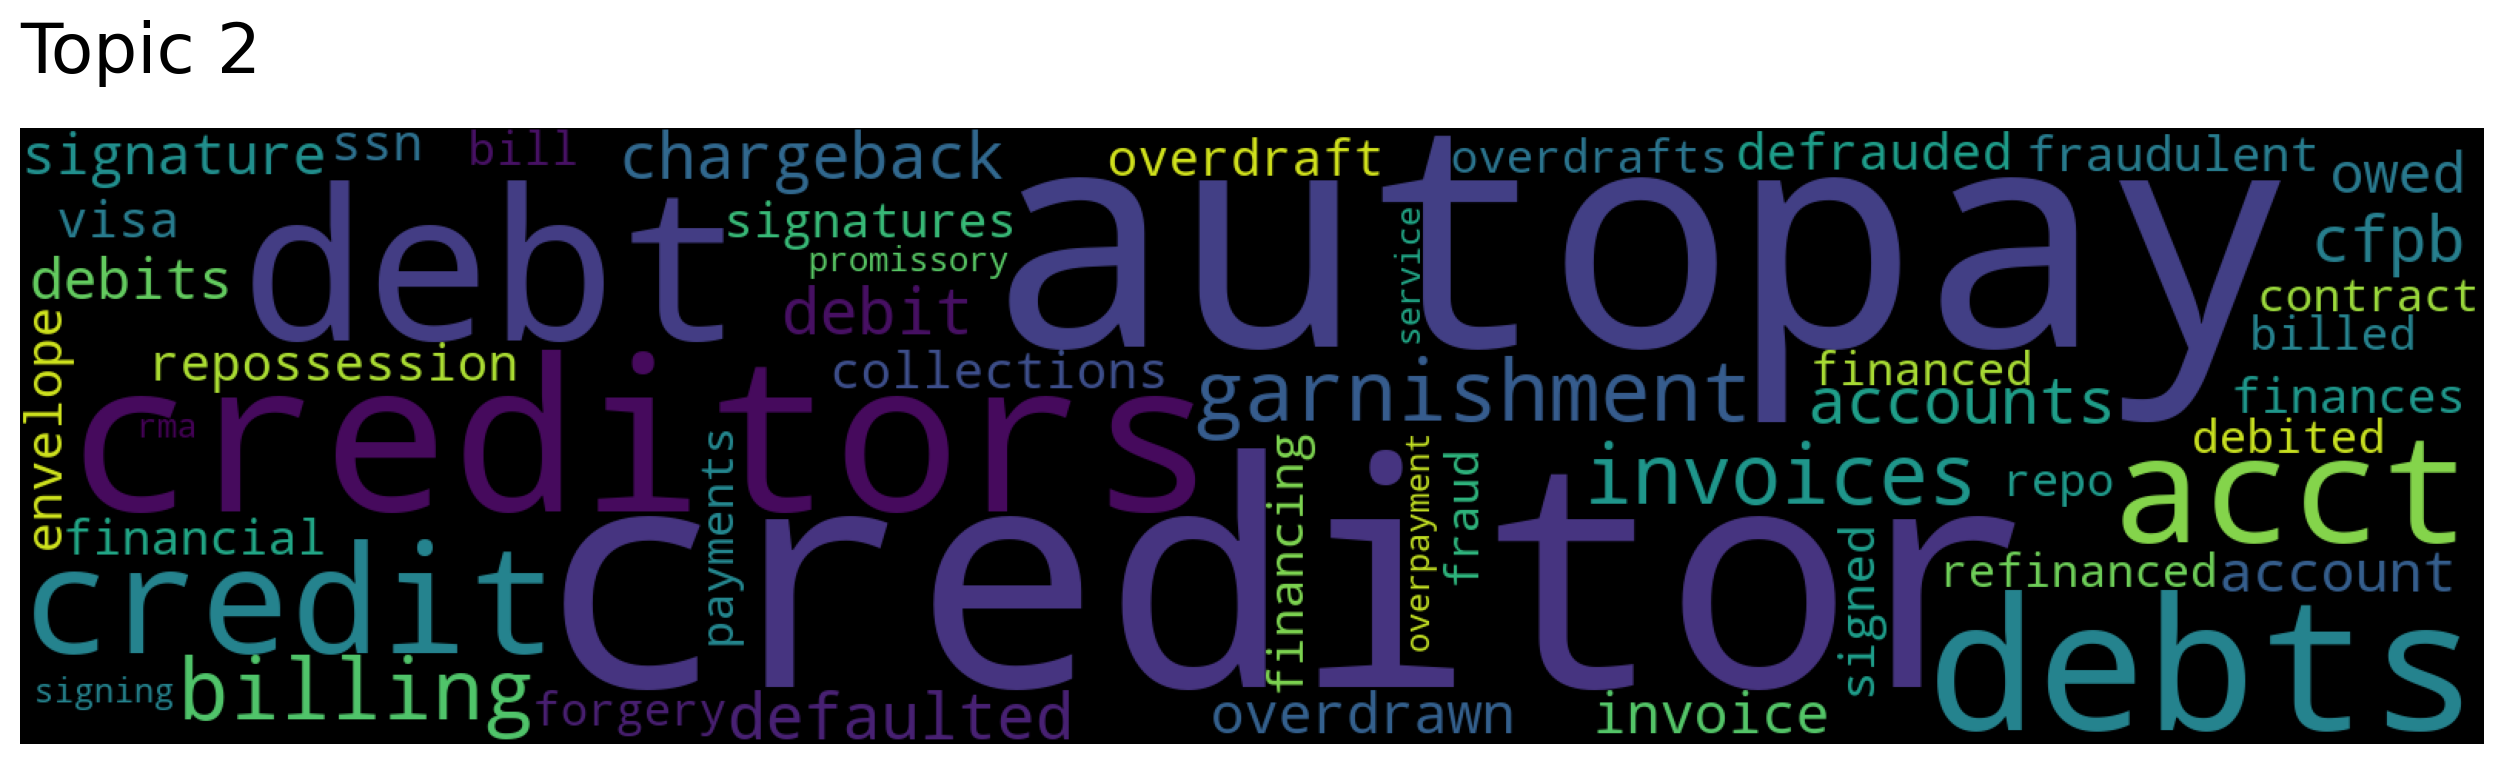

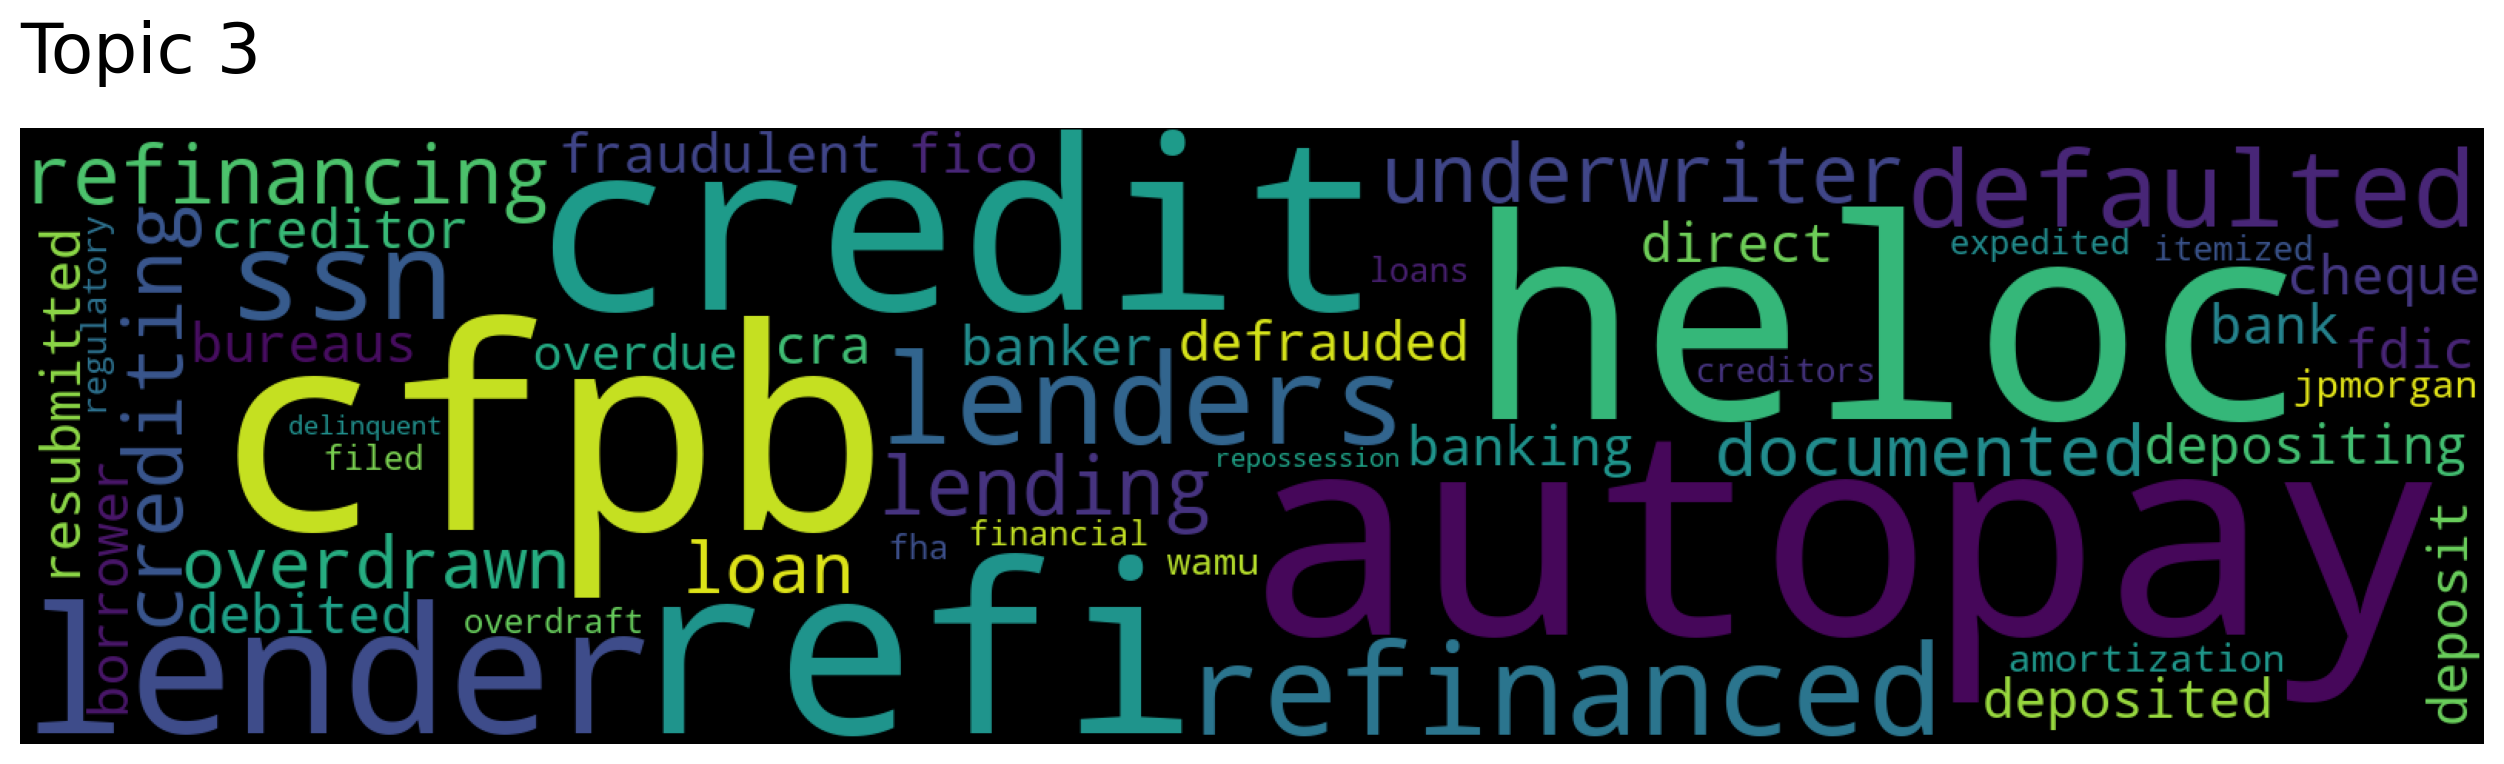

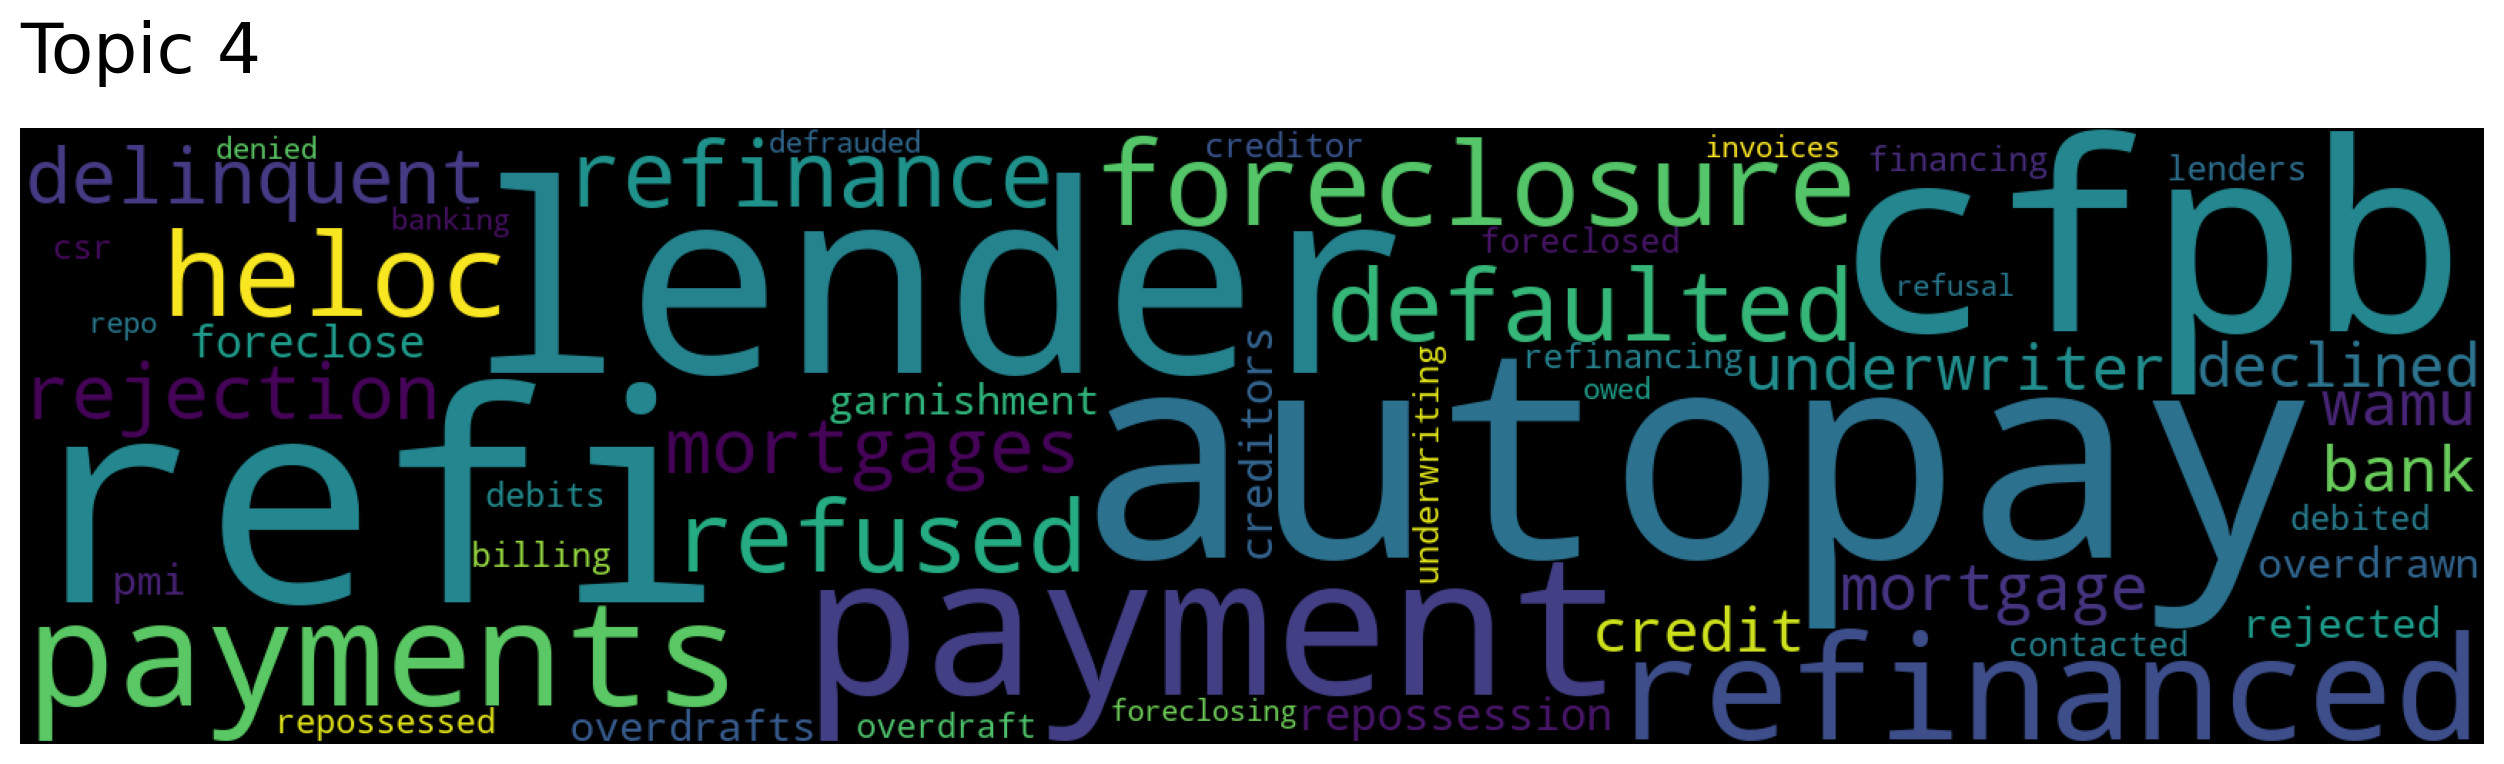

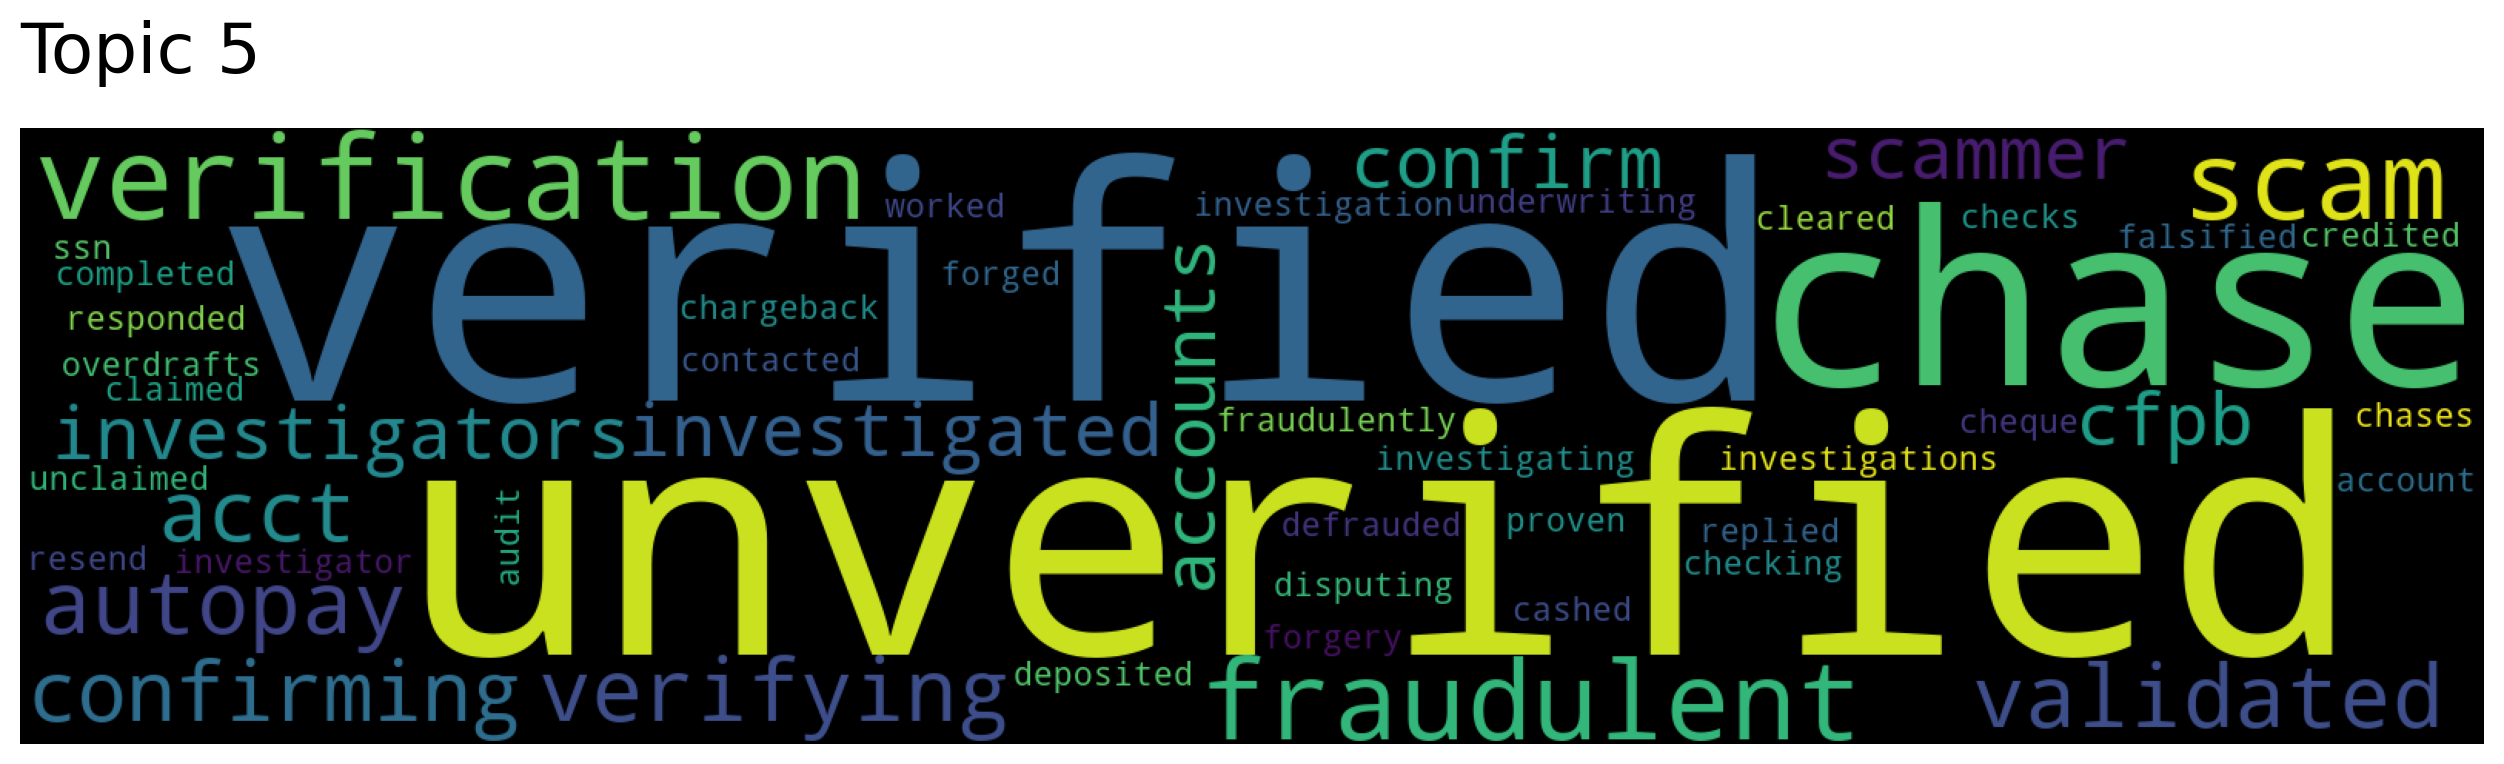

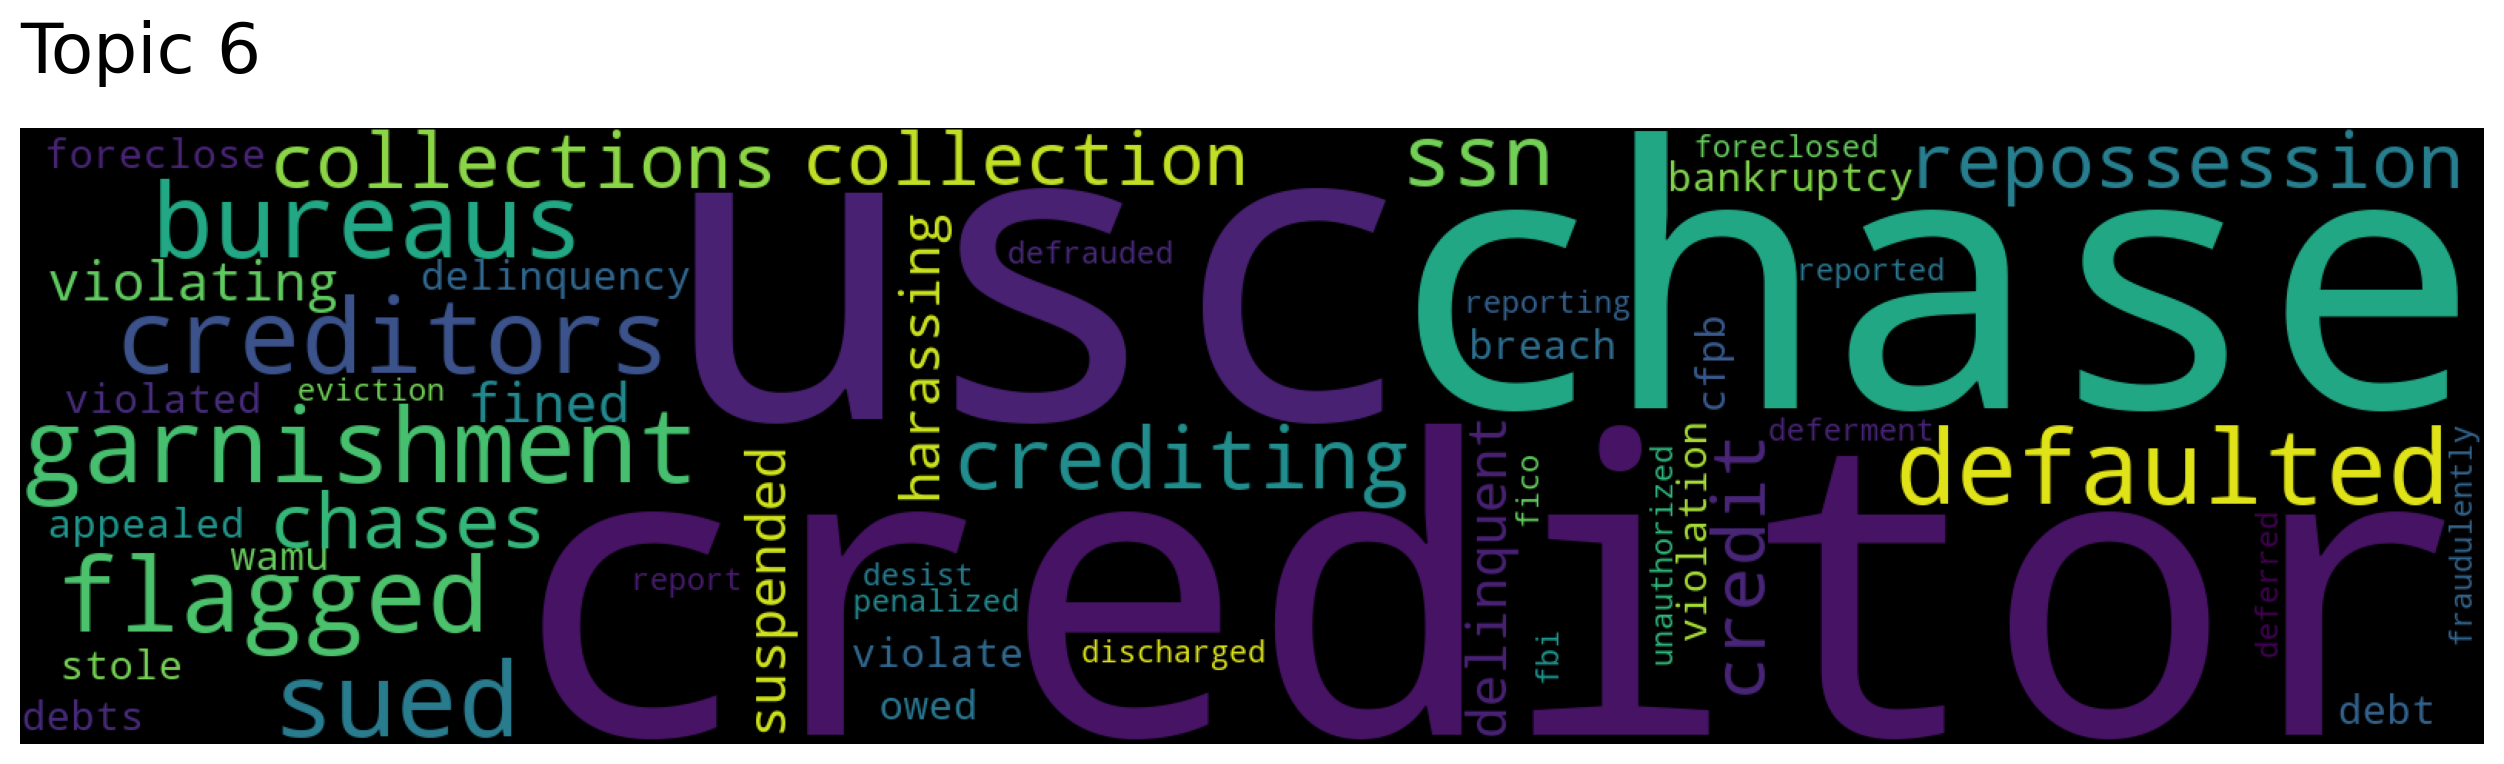

In [42]:
topic_words, word_scores, topic_nums = top2vec.get_topics(top2vec.get_num_topics())
for topic in topic_nums:
    top2vec.generate_topic_wordcloud(topic, background_color="black")

In [43]:
top2vec.save(os.path.join(os.getcwd(),'topic_models','final_t2v'))

## BERTopic

In [22]:
docs = list(removed_mask)

bertopic_base = BERTopic()
topics, ini_probs = bertopic_base.fit_transform(docs)

In [23]:
num_topics = len(bertopic_base.get_topics()) - 1
num_topics

144

In [24]:
bertopic_base.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

Count                               Name  \
Topic                                             
-1      8942                   -1_to_and_the_my   
 0      1487         0_check_account_funds_bank   
 1       715          1_overdraft_fees_fee_3400   
 2       696          2_points_offer_card_bonus   
 3       472      3_dispute_merchant_charge_the   
 4       393     4_closed_credit_accounts_cards   
 5       392               5_debit_atm_pin_card   
 6       329  6_escrow_insurance_taxes_mortgage   
 7       324    7_inquiry_inquiries_hard_credit   
 8       324  8_interest_balance_statement_paid   

                                          Representation  
Topic                                                     
-1      [to, and, the, my, was, chase, of, that, in, me]  
 0     [check, account, funds, bank, checks, deposit,...  
 1     [overdraft, fees, fee, 3400, charged, insuffic...  
 2     [points, offer, card, bonus, annual, fee, mile...  
 3     [dispute, merchant, charge, the, return, to, n...  
 4     [closed, credit, accounts, cards, card, close,...  
 5     [debit, atm, pin, card, transactions, claim, f...  
 6     [escrow, insurance, taxes, mortgage, property,...  
 7     [inquiry, inquiries, hard, credit, report, rem...  
 8     [interest, balance, statement, paid, purchases...

In [25]:
bertopic_base.visualize_barchart(top_n_topics = 16, n_words = 10)

### Fine Tuning

In [26]:
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  metric='cosine',
                  random_state=42
                  )

hdbscan_model = HDBSCAN(min_cluster_size=15, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=5)

bertopic_tune = BERTopic(
    top_n_words=10,
    n_gram_range=(1,2),
    min_topic_size=100,
    nr_topics="auto",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model
    )
topics, ini_probs = bertopic_tune.fit_transform(docs)

In [27]:
num_topics = len(bertopic_tune.get_topics()) - 1
num_topics

94

In [28]:
bertopic_tune.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

Count                                  Name  \
Topic                                                
-1     10199                      -1_the_to_and_my   
 0      1774                0_check_the_account_my   
 1       692          1_fees_overdraft_fee_account   
 2       687               2_points_card_offer_the   
 3       544  3_inquiry_inquiries_credit_my credit   
 4       338       4_modification_loan_mortgage_we   
 5       310           5_flight_dispute_the_refund   
 6       296     6_interest_balance_statement_paid   
 7       275            7_amazon_card_credit_chase   
 8       273         8_credit_closed_accounts_card   

                                          Representation  
Topic                                                     
-1      [the, to, and, my, that, was, chase, of, in, on]  
 0     [check, the, account, my, and, to, was, bank, ...  
 1     [fees, overdraft, fee, account, 3400, the, my ...  
 2     [points, card, offer, the, bonus, annual, for,...  
 3     [inquiry, inquiries, credit, my credit, hard, ...  
 4     [modification, loan, mortgage, we, to, and, th...  
 5     [flight, dispute, the, refund, to, chase, on, ...  
 6     [interest, balance, statement, paid, the, paym...  
 7     [amazon, card, credit, chase, the, credit card...  
 8     [credit, closed, accounts, card, cards, my, cr...

In [29]:
bertopic_tune.visualize_barchart(top_n_topics = 16, n_words = 10)

In [30]:
bertopic_tune.visualize_topics()

In [31]:
bertopic_tune.save(os.path.join(os.getcwd(),'topic_models','final_bertopic'), save_ctfidf=True, serialization="safetensors")